In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('data.csv/data.csv', encoding='latin1')

C:\Users\kashi\AppData\Local\Temp\ipykernel_36304\1248480007.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv/data.csv', encoding='latin1')


In [5]:
df= df.rename(columns={'rspm':'pm10'})

In [7]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True) #drop the rows with missing date
df = df.dropna(subset=['date', 'location','state']) #drop the rows where these parameters are missing
# Convert text columns to lowercase (standardization)
df['state'] = df['state'].str.lower().str.strip()
df['location'] = df['location'].str.lower().str.strip()

In [8]:
pollutants = ['so2', 'no2', 'pm10', 'spm', 'pm2_5']
df[pollutants] = df[pollutants].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['so2', 'no2', 'pm10', 'pm2_5'], how='all') #drops rows where all of these values are missing
df.drop(columns=['pm2_5', 'spm', 'agency', 'stn_code'], inplace=True)
#filling the null values in so2,no2,pm10 columns
for col in ['so2', 'no2', 'pm10']:
    df[col] = df.groupby('location')[col].transform(lambda x: x.fillna(x.median()))

#filling the null values in text columns
df['type'] = df['type'].fillna('Unknown')
df['location_monitoring_station'] = df['location_monitoring_station'].fillna('Unknown')

df.dropna(inplace=True) #drop rows still with any missing

C:\Users\kashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\kashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\kashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\kashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
 

In [9]:
df.drop_duplicates() #drops the duplicate rows
df.shape

(426770, 9)

In [15]:
def calculate_sub_index(cp, pollutant):
    breakpoints = {
        #'pm2_5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
        #         (91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
                 (251, 350, 201, 300), (351, 430, 301, 400), (431, 500, 401, 500)],
        'no2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
                (181, 280, 201, 300), (281, 400, 301, 400), (401, 500, 401, 500)],
        'so2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
                (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)]
    }
    for bp_lo, bp_hi, i_lo, i_hi in breakpoints[pollutant]:
        if bp_lo <= cp <= bp_hi:
            return ((i_hi - i_lo) / (bp_hi - bp_lo)) * (cp - bp_lo) + i_lo
    return np.nan

In [16]:
def compute_aqi(row):
    sub_indices = []
    for pollutant in ['pm10', 'no2', 'so2']:
        if pd.notna(row[pollutant]):
            sub_index = calculate_sub_index(row[pollutant], pollutant)
            if sub_index is not None:
                sub_indices.append(sub_index)
    return max(sub_indices) if sub_indices else np.nan


In [17]:
df['aqi'] = df.apply(compute_aqi, axis=1)
df = df.dropna(subset=['aqi'])


In [18]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'post_monsoon'

df['season'] = df['month'].apply(get_season)

df['state'] = df['state'].astype('category')
df['location'] = df['location'].astype('category')
df['season'] = df['season'].astype('category')

In [19]:
def categorize_aqi(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

df['aqi_category'] = df['aqi'].apply(categorize_aqi)

In [21]:
df.head()

,sampling_date,state,location,type,so2,no2,pm10,location_monitoring_station,date,aqi,year,month,season,aqi_category
0,February - M021990,andhra pradesh,hyderabad,"Residential, Rural and other Areas",4.8,17.4,83.0,Unknown,1990-02-01,83.0,1990,2,winter,Satisfactory
1,February - M021990,andhra pradesh,hyderabad,Industrial Area,3.1,7.0,83.0,Unknown,1990-02-01,83.0,1990,2,winter,Satisfactory
2,February - M021990,andhra pradesh,hyderabad,"Residential, Rural and other Areas",6.2,28.5,83.0,Unknown,1990-02-01,83.0,1990,2,winter,Satisfactory
3,March - M031990,andhra pradesh,hyderabad,"Residential, Rural and other Areas",6.3,14.7,83.0,Unknown,1990-03-01,83.0,1990,3,summer,Satisfactory
4,March - M031990,andhra pradesh,hyderabad,Industrial Area,4.7,7.5,83.0,Unknown,1990-03-01,83.0,1990,3,summer,Satisfactory


In [22]:
df = df.sort_values(['location', 'date'])

In [24]:
# 2. Create rolling features: past 7 days' AQI for each location
def create_lag_features(df, n_lags=7):
    df_lagged = df.copy()
    for lag in range(1, n_lags + 1):
        df_lagged[f'aqi_lag_{lag}'] = df_lagged.groupby('location')['aqi'].shift(lag)
    return df_lagged

df = create_lag_features(df)

C:\Users\kashi\AppData\Local\Temp\ipykernel_36304\2236280616.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lagged[f'aqi_lag_{lag}'] = df_lagged.groupby('location')['aqi'].shift(lag)
C:\Users\kashi\AppData\Local\Temp\ipykernel_36304\2236280616.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lagged[f'aqi_lag_{lag}'] = df_lagged.groupby('location')['aqi'].shift(lag)
C:\Users\kashi\AppData\Local\Temp\ipykernel_36304\2236280616.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

In [25]:
# 3. Drop rows with NaN due to shifting (first 7 days per location)
df = df.dropna(subset=[f'aqi_lag_{i}' for i in range(1, 8)] + ['aqi'])


In [26]:
df.head()

,sampling_date,state,location,type,so2,no2,pm10,location_monitoring_station,date,aqi,...,month,season,aqi_category,aqi_lag_1,aqi_lag_2,aqi_lag_3,aqi_lag_4,aqi_lag_5,aqi_lag_6,aqi_lag_7
368245,7/1/1987,uttar pradesh,agra,Residential,6.0,4.7,166.0,Unknown,1987-01-07,144.187919,...,1,winter,Moderate,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919
368247,7/1/1987,uttar pradesh,agra,Sensitive,4.2,8.8,166.0,Unknown,1987-01-07,144.187919,...,1,winter,Moderate,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919
368251,8/1/1987,uttar pradesh,agra,Residential,4.8,3.5,166.0,Unknown,1987-01-08,144.187919,...,1,winter,Moderate,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919
368252,8/1/1987,uttar pradesh,agra,Sensitive,3.2,5.5,166.0,Unknown,1987-01-08,144.187919,...,1,winter,Moderate,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919
368254,9/1/1987,uttar pradesh,agra,Residential,5.2,3.8,166.0,Unknown,1987-01-09,144.187919,...,1,winter,Moderate,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919,144.187919


In [28]:
# 4. Add date-related features
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

# 5. Encode location
le = LabelEncoder()
df['location_enc'] = le.fit_transform(df['location'])

# 6. Prepare input (X) and output (y) features
feature_cols = [f'aqi_lag_{i}' for i in range(1, 8)] + ['month', 'dayofweek', 'location_enc']
X = df[feature_cols]
y = df['aqi']

In [29]:
# 7. Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [30]:

# 8. Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

RMSE: 31.00896900949753
R^2 Score: 0.4757076036186383


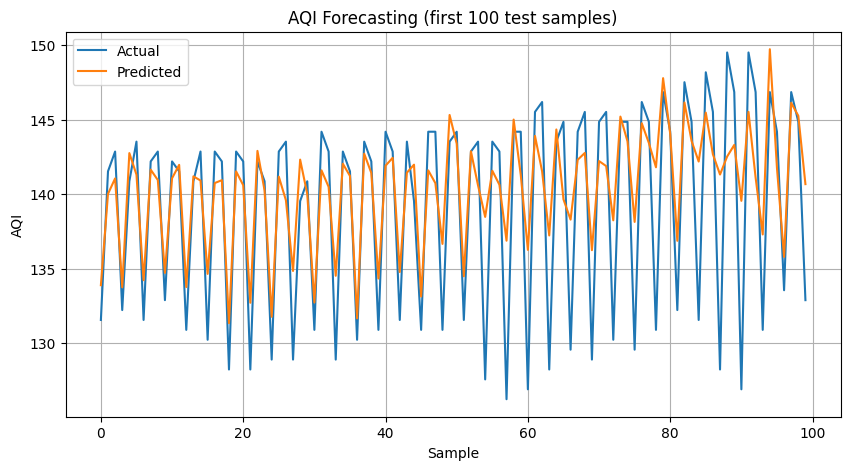

In [31]:

# 9. Evaluate
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2 Score:", r2_score(y_test, y_pred))

# 10. Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.title('AQI Forecasting (first 100 test samples)')
plt.xlabel('Sample')
plt.ylabel('AQI')
plt.grid()
plt.show()
